In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm

from itertools import combinations 
import matplotlib.pyplot as plt
import random

## 6.5.1 Best Subset Selection

In [2]:
Hitters = pd.read_table("Hitters.csv", sep = ',', index_col=0)

In [3]:
print(Hitters.columns, "\n")
print(Hitters.shape, "\n")
print(Hitters.Salary.isnull().sum())

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague'],
      dtype='object') 

(322, 20) 

59


In [4]:
Hitters.dropna(axis=0, how='any', inplace=True)
print(Hitters.shape, "\n")
print(Hitters.Salary.isnull().sum())

(263, 20) 

0


In [7]:
variables = list (set( Hitters.columns.values.tolist()) -{"Salary"})
print(len(variables))
print(len(list(combinations(variables, 10))))


19
92378


In [8]:
def best_subset(data, target, maxi = 3): #this is exhaustive approach, be careful with var number
    variables = list(set(data.columns.values.tolist()) - {target})
    var_comb = list(combinations(variables, maxi))
    forms = ["+".join(i) for i in var_comb]
    
    forms = [target + "~" + i for i in forms]
    rsq = [sm.ols(formula = f, data = data).fit().rsquared for f in forms] # can also use BIC RSS etc. instead of rsq
    ind_max = np.argmax(rsq)
    
    return var_comb[ind_max],rsq[ind_max] 
    

In [9]:
best_subset(Hitters, "Salary", 4) #best variable subset and corresponding model rsquared

(('Hits', 'CRBI', 'PutOuts', 'Division'), 0.47540665339478705)

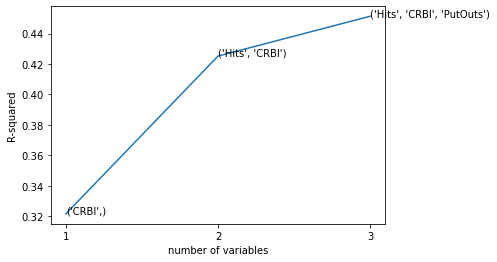

In [10]:
var_num = [1,2,3]
rsq = []
for v in var_num:
    rsq.append(best_subset(Hitters, "Salary", v))
    
plt.plot(var_num, [i[1] for i in rsq])
plt.xticks(var_num)
plt.ylabel("R-squared")
plt.xlabel("number of variables")
for i in range(len(var_num)):
    plt.text(var_num[i], rsq[i][1], rsq[i][0])
plt.show()

## 6.5.2 Forward and Backward Stepwise Selection

In [ ]:
def stepwise(data, target, method = "forward"): #again can modify this function to gain more flexibility
    variables = list(set(data.columns.values.tolist()) - {target})
    result = []
    if method == "forward":
        subset = set()
        while (len(variables) > 0):
            cur = [subset.union({var}) for var in variables]
            forms = [target + "~" + "+".join(c) for c in cur]
            rsq = [sm.ols(formula = f, data = data).fit().rsquared for f in forms] 
            ind_max = np.argmax(rsq)
            subset = set(cur[ind_max])
            result.append((subset,rsq[ind_max]))
            del variables[ind_max]
    else:
        while (len(variables) > 1):
            cur = []
            for i in range(len(variables)):
                t = variables.copy()
                del t[i]
                cur.append(t)
            forms = [target + "~" + "+".join(c) for c in cur]
            rsq = [sm.ols(formula = f, data = data).fit().rsquared for f in forms] 
            ind_max = np.argmax(rsq)
            result.append((cur[ind_max],rsq[ind_max]))
            del variables[ind_max]
        
    return result

In [ ]:
stepwise(Hitters, "Salary", "backward")

In [ ]:
var_num = range(1,20)
rsq = stepwise(Hitters, "Salary")
    
plt.plot(var_num, [i[1] for i in rsq])
plt.xticks(var_num)
plt.ylabel("R-squared")
plt.xlabel("number of variables")
plt.show()

## 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [ ]:
random.seed(1) ## two "random"s, random and np.random

In [11]:
def train_test_split(data, rate):
    n = data.shape[0]
    train = random.sample(list(range(n)), int(rate*n))
    test = list(set(range(n))-set(train))
    return data.iloc[train], data.iloc[test]

In [13]:
def best_subset_val(data, target, maxi = 3, rate=0.7): #this is exhausted approach, be careful with var number
    variables = list(set(data.columns.values.tolist()) - {target})
    var_comb = list(combinations(variables, maxi))
    forms = ["+".join(i) for i in var_comb]
    forms = [target + "~" + i for i in forms]
    train, test = train_test_split(data,rate)
    pred = [sm.ols(formula = f, data = train).fit().predict(test) for f in forms] 
    rsq = [sum((p-test.loc[:,target].tolist())**2) / len(test) for p in pred]
    ind_max = np.argmin(rsq) #this is mean square error
    
    return var_comb[ind_max],rsq[ind_max] 

In [15]:
best_subset_val(Hitters.copy(), "Salary", maxi=2, rate=0.7)

(('CHits', 'Walks'), 117430.40768237707)

In [16]:
def best_subset_cv(data, target, maxi = 3, cv = 10):
    variables = list(set(data.columns.values.tolist()) - {target})
    var_comb = list(combinations(variables, maxi))
    forms = ["+".join(i) for i in var_comb]
    forms = [target + "~" + i for i in forms]
    
    n = data.shape[0]
    total = random.sample(list(range(n)),n)
    data = data.iloc[total]
    step = int(n/10)
    index = data.index.tolist()
    
    result = dict(zip(forms, [0]*len(var_comb)))
    for i in range(cv):
        test = data.iloc[total[i*step:min((i+1)*step, n)]]
        train = data.drop(index[i*step:min((i+1)*step, n)])
        for f in forms:
            result[f] += sum((sm.ols(formula = f, data = train).fit().predict(test)-test.loc[:,target].tolist())**2) / len(test)
            
    for f in forms:
        result[f] /= cv
        
    return min(result, key=result.get)

In [17]:
best_subset_cv(Hitters, "Salary", maxi = 2)

'Salary~Hits+CRBI'

## 6.6.1 Ridge Regression

In [20]:
grid = [10**i for i in np.linspace(10,-2,100)]
target = 'Salary'
var = list(set(Hitters.columns.tolist()) - {target})

In [21]:
np.linspace(10,-2,100)

array([10.        ,  9.87878788,  9.75757576,  9.63636364,  9.51515152,
        9.39393939,  9.27272727,  9.15151515,  9.03030303,  8.90909091,
        8.78787879,  8.66666667,  8.54545455,  8.42424242,  8.3030303 ,
        8.18181818,  8.06060606,  7.93939394,  7.81818182,  7.6969697 ,
        7.57575758,  7.45454545,  7.33333333,  7.21212121,  7.09090909,
        6.96969697,  6.84848485,  6.72727273,  6.60606061,  6.48484848,
        6.36363636,  6.24242424,  6.12121212,  6.        ,  5.87878788,
        5.75757576,  5.63636364,  5.51515152,  5.39393939,  5.27272727,
        5.15151515,  5.03030303,  4.90909091,  4.78787879,  4.66666667,
        4.54545455,  4.42424242,  4.3030303 ,  4.18181818,  4.06060606,
        3.93939394,  3.81818182,  3.6969697 ,  3.57575758,  3.45454545,
        3.33333333,  3.21212121,  3.09090909,  2.96969697,  2.84848485,
        2.72727273,  2.60606061,  2.48484848,  2.36363636,  2.24242424,
        2.12121212,  2.        ,  1.87878788,  1.75757576,  1.63

In [22]:
print(grid)

[10000000000.0, 7564633275.54629, 5722367659.35022, 4328761281.083061, 3274549162.877732, 2477076355.991714, 1873817422.8603868, 1417474162.9268076, 1072267222.0103253, 811130830.789689, 613590727.3413163, 464158883.3612773, 351119173.4215127, 265608778.2946684, 200923300.2565046, 151991108.2952933, 114975699.53977357, 86974900.26177834, 65793322.465756826, 49770235.64332114, 37649358.067924716, 28480358.68435805, 21544346.900318824, 16297508.346206434, 12328467.39442066, 9326033.468832199, 7054802.310718645, 5336699.231206302, 4037017.2585965497, 3053855.5088334125, 2310129.700083158, 1747528.4000076829, 1321941.1484660287, 1000000.0, 756463.3275546291, 572236.765935022, 432876.12810830615, 327454.9162877725, 247707.6355991709, 187381.7422860383, 141747.4162926805, 107226.72220103232, 81113.08307896872, 61359.072734131754, 46415.888336127726, 35111.917342151275, 26560.87782946684, 20092.33002565046, 15199.11082952933, 11497.569953977356, 8697.490026177835, 6579.332246575683, 4977.0235

In [23]:
reg = [sm.ols(formula = target+'~'+"+".join(var), data = Hitters).fit_regularized(alpha=g, L1_wt=0.) for g in grid]

In [28]:
reg[99].params


array([ 1.33087694e+02,  5.57376491e+01, -1.08754284e+02, -1.42537451e+01,
       -2.36770948e+00,  1.23782363e-01, -3.06431522e+00, -8.06555875e-01,
        4.23083796e+00, -1.92804000e+00,  3.61540183e-01,  7.44920040e+00,
        1.47722682e+00,  8.07364546e-01,  6.20864644e+00, -1.86114304e-01,
       -1.76048641e-01,  2.83142646e-01, -1.01463368e+00, -1.13972152e+00])

In [31]:
grid[10]
reg[10].params


array([8.57759666e-07, 3.99355150e-07, 3.66547518e-07, 3.96894351e-07,
       5.47498176e-05, 8.71576397e-04, 7.35059038e-06, 3.14825283e-04,
       1.21408968e-05, 3.88393481e-04, 1.04584085e-04, 1.06859128e-04,
       4.42047564e-04, 4.13648721e-04, 4.22461063e-05, 9.01227073e-05,
       3.13062990e-03, 3.10715531e-04, 5.25845159e-05, 7.62100123e-06])

## 6.6.2 The Lasso

In [32]:
reg2 = [sm.ols(formula = target+'~'+"+".join(var), data = Hitters).fit_regularized(alpha=g, L1_wt=1.) for g in grid]

In [33]:
print(grid[0])

10000000000.0


In [34]:
reg2[0].params

Intercept         0.0
League[T.N]       0.0
Division[T.W]     0.0
NewLeague[T.N]    0.0
Runs              0.0
CHits             0.0
Errors            0.0
CWalks            0.0
HmRun             0.0
AtBat             0.0
Assists           0.0
Hits              0.0
CRuns             0.0
CRBI              0.0
Walks             0.0
CHmRun            0.0
CAtBat            0.0
PutOuts           0.0
RBI               0.0
Years             0.0
dtype: float64

In [35]:
reg2[60].params

Intercept         0.000000
League[T.N]       0.000000
Division[T.W]     0.000000
NewLeague[T.N]    0.000000
Runs              3.867226
CHits             0.479082
Errors            0.000000
CWalks            0.000000
HmRun             0.000000
AtBat             0.000000
Assists           0.000000
Hits              0.000000
CRuns             0.117522
CRBI              0.328020
Walks             0.000000
CHmRun            0.166649
CAtBat           -0.104835
PutOuts           0.314770
RBI               0.000000
Years             0.000000
dtype: float64

## 6.7.1 Principle Components Regression

In [ ]:
from statsmodels.multivariate.pca import PCA

In [ ]:
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])
print(dummies)
y = Hitters.Salary
X_ = Hitters.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

In [ ]:
n = X.shape[0]
train_ind = random.sample(list(range(n)), int(0.7*n))
test_ind = list(set(range(n)) - set(train_ind))
index = X.index.tolist()
x_train = X.iloc[train_ind]
x_test = X.iloc[test_ind]
y_train = y.iloc[train_ind]
y_test = y.iloc[test_ind]
print(index)

In [ ]:
n = X.shape[1]
print(n)
pc = PCA(x_train)
newloading = np.dot(x_train,pc.eigenvecs)
print(newloading.shape)
print(pc.factors.shape)

In [ ]:

type(pc.eigenvecs)
first_two=pc.eigenvecs[['eigenvec_00','eigenvec_01']]
newloading = np.dot(x_train,first_two)
print(newloading.shape)

In [ ]:
import statsmodels.regression.linear_model as sm

In [ ]:
#reg = sm.OLS(endog = y_train, exog = np.dot(x_train,first_two)).fit()
reg = sm.OLS(endog = y_train, exog = np.dot(x_train,pc.eigenvecs)).fit()

In [ ]:
#y_pred = reg.predict(np.dot(x_test,first_two))
y_pred = reg.predict(np.dot(x_test,pc.eigenvecs))
y_pred[:10]

## 6.7.2 Partial Least Square

In [ ]:
from sklearn.cross_decomposition import PLSRegression

In [ ]:
pls2 = PLSRegression(n_components=2)
pls2.fit(x_train, y_train)
y_pred = pls2.predict(x_test)
y_pred[:10]